# DBSCAN grid search on iterative clustering

Clustering with epsilon 0.6 and min_samples 10 produced the least 

Output is visualized in dbscan_cluster_analysis.ipynb

In [1]:
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from cuml.cluster import KMeans as cuKMeans
from cuml.neighbors import NearestNeighbors
import cupy

In [4]:
from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd
from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN

In [5]:
import torch

In [61]:
output_dir='/rapids/notebooks/host/representations/output/iterative/'

In [62]:
input_dir='/rapids/notebooks/host/representations/output/low_epsilon/'

In [7]:
# cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
# client = Client(cluster)

In [71]:
client = Client("tcp://127.0.0.1:38825")
client

Client Scheduler: tcp://127.0.0.1:38825 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 125.50 GiB


In [9]:
import glob

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

def layer(index):
    layer_head_location = index % 144
    return int(layer_head_location/12)
    
def head(index):
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    return layer_head_location % 12

def index_layer_heads(df):
    df.rename(columns={0:'cluster'},inplace=True)
    df['layer'] = (df.index.to_series().apply(layer))
    df['head'] = (df.index.to_series().apply(head))
    return df

In [11]:
# load full partitioned dataset - read in as pandas df,
# for some reason dask cuml dbscan doesn't accept a dask cdDF?
# https://docs.rapids.ai/api/cuml/nightly/api.html?highlight=regression#multi-node-multi-gpu-algorithms
gdf = pd_read_pattern('/rapids/notebooks/host/representations/final/partitions/half/*.csv')
# loading  0-125,000 skipping 10,000 at a time - 300 examples per file

In [63]:
df = torch.load(os.path.join(input_dir,'dask_dbscan_0.6_10_label_df.bin'))

In [64]:
cluster_counts = df['cluster'].value_counts(sort=True)
print(f'clusters: {len(cluster_counts)}\n')
print(cluster_counts[0:9])

clusters: 646

-1     476443
 0      83688
 23        33
 1         25
 15        25
 13        23
 18        21
 10        19
 25        18
Name: cluster, dtype: int64


In [65]:
df_0 = df[df['cluster'] == 0]
df_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83688 entries, 2 to 561489
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cluster  83688 non-null  int32
 1   layer    83688 non-null  int64
 2   head     83688 non-null  int64
dtypes: int32(1), int64(2)
memory usage: 2.2 MB


In [66]:
df_0.head()

,cluster,layer,head
2,0,0,2
3,0,0,3
8,0,0,8
10,0,0,10
13,0,1,1


In [67]:
df_0_indices = df_0.index.to_list()

In [68]:
gdf_0 = gdf[gdf.index.isin(df_0_indices)]
gdf_0.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
2,0.000000,0.000915,0.011240,0.017890,0.028221,0.000000,0.034561,0.068724,0.003225,0.002210,...,0.030051,0.000000,0.015314,0.039816,0.000000,0.004509,0.000000,0.00853,0.004781,0.031056
3,0.000000,0.001661,0.008804,0.026601,0.039442,0.000000,0.033881,0.074009,0.025130,0.009409,...,0.038725,0.000194,0.012723,0.045480,0.000000,0.007676,0.000000,0.00000,0.002801,0.016614
8,0.000000,0.000000,0.013861,0.009974,0.020393,0.000000,0.000000,0.080442,0.000000,0.006803,...,0.000000,0.026788,0.012317,0.040445,0.000028,0.031078,0.000561,0.00000,0.000368,0.034905
10,0.000000,0.000000,0.013547,0.001830,0.035910,0.001115,0.010958,0.072014,0.007152,0.010255,...,0.029918,0.000000,0.008261,0.051248,0.008916,0.001374,0.000000,0.00000,0.000655,0.012605
13,0.000444,0.000000,0.013867,0.002874,0.026968,0.000000,0.021565,0.062461,0.002077,0.028647,...,0.011395,0.000000,0.033766,0.046177,0.000000,0.018440,0.000000,0.00000,0.000000,0.017967


In [69]:
len(gdf_0)

83688

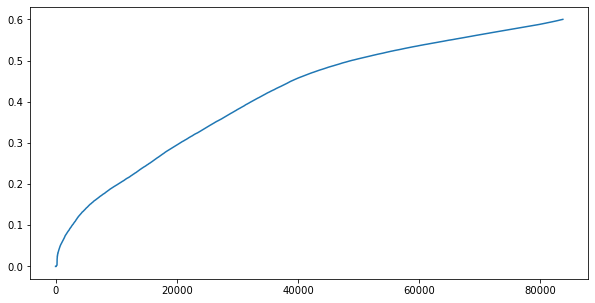

In [52]:
# %matplotlib widget
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(gdf_0)
distances, idx = nn.kneighbors(gdf_0)
distances = cupy.asnumpy(distances)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

In [60]:

results = pd.DataFrame(columns=['eps','min_samples','n_clusters','n_noise'])

epsilon_range = np.arange(0.30,0.60,0.1)
min_sample_range = range(5,30,5)

for e in epsilon_range:
    for m in min_sample_range:
        eps = e
        min_samples = m
        cuml_dbscan = daskDBSCAN( eps = eps,
                                  metric='euclidean',
                                  min_samples = min_samples,
                                  max_mbytes_per_batch = 10000
                                )
        print(f'Fitting e: {eps} s: {min_samples}')
        trained_DBSCAN = cuml_dbscan.fit(gdf_0)
        labels = trained_DBSCAN.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print(f'e: {eps} s: {min_samples} c: {n_clusters_} n: {n_noise_}')

        df_labels = pd.DataFrame(labels)
        df_labels = index_layer_heads(df_labels)

        torch.save(df_labels, os.path.join(output_dir,f'dask_dbscan_{eps}_{min_samples}_label_df.bin'))

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters_,
            'n_noise': n_noise_
        }, ignore_index=True)

torch.save(results, os.path.join(output_dir,'results_0.3-0.5_5-30_df.bin'))

Fitting e: 0.3 s: 5
e: 0.3 s: 5 c: 309 n: 81765
Fitting e: 0.3 s: 10
e: 0.3 s: 10 c: 9 n: 83547
Fitting e: 0.3 s: 15
e: 0.3 s: 15 c: 2 n: 83658
Fitting e: 0.3 s: 20
e: 0.3 s: 20 c: 0 n: 83688
Fitting e: 0.3 s: 25
e: 0.3 s: 25 c: 0 n: 83688
Fitting e: 0.4 s: 5
e: 0.4 s: 5 c: 524 n: 77307
Fitting e: 0.4 s: 10
e: 0.4 s: 10 c: 31 n: 80479
Fitting e: 0.4 s: 15
e: 0.4 s: 15 c: 3 n: 80978
Fitting e: 0.4 s: 20
e: 0.4 s: 20 c: 3 n: 81141
Fitting e: 0.4 s: 25
e: 0.4 s: 25 c: 3 n: 81299
Fitting e: 0.5 s: 5
e: 0.5 s: 5 c: 737 n: 60946
Fitting e: 0.5 s: 10
e: 0.5 s: 10 c: 54 n: 67121
Fitting e: 0.5 s: 15
e: 0.5 s: 15 c: 14 n: 68540
Fitting e: 0.5 s: 20
e: 0.5 s: 20 c: 6 n: 69325
Fitting e: 0.5 s: 25
e: 0.5 s: 25 c: 4 n: 69924


In [ ]:
# fitting epsilon 0.6 n 5-25 resulted in only one cluster for min_samples 5, so was aborted

# re-clustering the largest cluster of .7 min_samples 10 initial clustering - which has a much lower noise to sample point ratio at ~50%

In [81]:
input_dir='/rapids/notebooks/host/representations/output/low_epsilon/'
output_dir='/rapids/notebooks/host/representations/output/iterative_0.7_10/'
df = torch.load(os.path.join(input_dir,'dask_dbscan_0.7_10_label_df.bin'))

In [82]:
cluster_counts = df['cluster'].value_counts(sort=True)
print(f'clusters: {len(cluster_counts)}\n')
print(cluster_counts[0:9])

clusters: 283

-1      296926
 0      260713
 15        162
 3          93
 14         54
 206        49
 40         43
 29         42
 76         41
Name: cluster, dtype: int64


In [83]:
df_0 = df[df['cluster'] == 0]
df_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260713 entries, 0 to 561557
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   cluster  260713 non-null  int32
 1   layer    260713 non-null  int64
 2   head     260713 non-null  int64
dtypes: int32(1), int64(2)
memory usage: 7.0 MB


In [84]:
df_0_indices = df_0.index.to_list()

In [87]:
gdf_0 = gdf[gdf.index.isin(df_0_indices)]
len(gdf_0)

260713

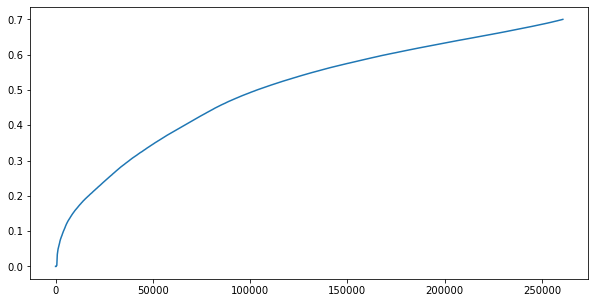

In [86]:
# %matplotlib widget
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(gdf_0)
distances, idx = nn.kneighbors(gdf_0)
distances = cupy.asnumpy(distances)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

In [ ]:
epsilon_range = np.arange(0.35,0.65,0.1)
min_sample_range = range(5,15,5)


for e in epsilon_range:
    for m in min_sample_range:
        eps = e
        min_samples = m
        cuml_dbscan = daskDBSCAN( eps = eps,
                                  metric='euclidean',
                                  min_samples = min_samples,
                                  max_mbytes_per_batch = 10000
                                )

        trained_DBSCAN = cuml_dbscan.fit(gdf_0)
        labels = trained_DBSCAN.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print(f'e: {eps} s: {min_samples} c: {n_clusters_} n: {n_noise_}')
        
        df_labels = pd.DataFrame(labels)
        df_labels = index_layer_heads(df_labels)

        torch.save(df_labels, os.path.join(output_dir,f'dask_dbscan_{eps}_{min_samples}_label_df.bin'))

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters_,
            'n_noise': n_noise_
        }, ignore_index=True)

torch.save(results, os.path.join(output_dir,'results_0.35-0.55_5-10_df.bin'))

e: 0.35 s: 5 c: 644 n: 255453
e: 0.35 s: 10 c: 22 n: 259380
